In [1]:
import torch
import torch.nn as nn 
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from sklearn.metrics import roc_curve, roc_auc_score

# Vaccine data

DataDriven competition. Try to predict the intake of two different vaccines, flu and H1N1, based on demographic data.

https://www.drivendata.org/competitions/66/flu-shot-learning/

## Data loading and formatting

First step is to get all the data in a Pandas dataframe. We will format it in a way we can process easily all its information. Later, we will do a exploratory analysis on the Dataframe 

In [14]:
def read_and_format_data(path, read_labels=True):
    """
    This function takes the CSV file designated by path and applies all the formatting we need,
    changing the strings to qualitative numbers to make analysis easier
    """
    
    data = pd.read_csv(path + "_features.csv")
    data.drop(columns="respondent_id", inplace=True)

    #If we are in the training set, append the solutions to the end of the file
    if read_labels:
        labels = pd.read_csv(path + "_labels.csv")
        labels.drop(columns="respondent_id", inplace=True)
        data = pd.concat((data, labels), axis=1)
    
    # --- Create some dictionaries in order to change all strings for numerical integer identifiers
    age_groups = {'18 - 34 Years': 0,
                  '35 - 44 Years': 1,
                  '45 - 54 Years': 2,
                  '55 - 64 Years': 3,
                  '65+ Years': 4}
    
    sex = {"Female": 0,
           "Male": 1}
    
    race = {'White': 0,
            'Black': 1,
            'Other or Multiple': 2,
            'Hispanic': 3}
    
    education = {'< 12 Years': 0,
                 '12 Years': 1,
                 'Some College': 2,
                 'College Graduate': 3}
    
    income = {'Below Poverty': 0,
              '<= $75,000, Above Poverty': 1,
              '> $75,000': 2}

    marital = {'Not Married': 0, 
               'Married': 1}
    
    rent = {'Own': 0, 
            'Rent': 1}
    
    labor = {'Not in Labor Force' : 0,
             'Employed' : 1, 
             'Unemployed' : 2}
    
    msa = {'Non-MSA': 0, 
           'MSA, Not Principle  City': 1,
           'MSA, Principle City': 2}
    
    #Do the same with the codes associated to industry and occupation. I will not do this by hand
    industry = {}
    j = 0
    for code in data["employment_industry"].unique():
        if not pd.isna(code):
            print(code,j)
            industry[code] = j
            j += 1    
    
    occupation = {}
    j = 0
    for code in data["employment_occupation"].unique():
        if not pd.isna(code):
            print(code,j)
            occupation[code] = j
            j += 1    
            
    region = {}
    j = 0
    for code in data["hhs_geo_region"].unique():
        if not pd.isna(code):
            region[code] = j
            j += 1    
    
    #Then zip all dictionaries together with their correspondent labels...
    dictionaries = [age_groups, education, sex, race, income, marital, rent, 
                    labor, industry, occupation, msa, region]
    labels = ["age_group", "education", "sex", "race", "income_poverty", "marital_status", 
              "rent_or_own", "employment_status", "employment_industry", "employment_occupation",
              "census_msa", "hhs_geo_region"]
    
    #...and use this to perform the actual replacements
    for dic,lab in zip(dictionaries,labels):
        for key in dic:
            data[lab].replace(key, dic[key], inplace=True)
            
    
    #Store which columns contain cualitative information (useful for later)
    cualitative_cols = ["age_group", "race", "education", "income_poverty", "employment_status", 
                           "employment_industry", "employment_occupation", "census_msa", "hhs_geo_region"]
    
    #Store how many classes they store
    nclasses = [len(dic) for dic in [age_groups, race, education, income, labor, industry, occupation, msa, region]]
        
    return data, cualitative_cols, nclasses


def delete_rows_empty(df, labels, cols):
    """
    Delete some rows with have simultaneously empty data in the selected columns
    """
    
    #Create a mask that is True in all rows that have simultaneously NAN in selected cols
    mask = df[cols[0]].isna()
    for c in cols[1:]:
        mask = mask & df[c].isna()
    
    df = df[~mask] #Select it
    labels = labels[~mask]

    #Ensure correct indexing
    df.reset_index(inplace=True)
    df.drop(columns="index", inplace=True)
    
    labels.reset_index(inplace=True)
    labels.drop(columns="index", inplace=True)
    
    return

In [15]:
#Load the data and print shape and column names to ensure everything correct
data, cualitative_cols, n_classes = read_and_format_data("datasets/vacunas/training_set")

print(data.shape)
print(data.columns)

print(data.iloc[:,15:21].columns)
print(data.iloc[:,3:8].columns)
print(data["hhs_geo_region"].unique().size, 
      data["employment_occupation"].unique().size, 
      data["employment_status"].unique().size,
     )

pxcmvdjn 0
rucpziij 1
wxleyezf 2
saaquncn 3
xicduogh 4
ldnlellj 5
wlfvacwt 6
nduyfdeo 7
fcxhlnwr 8
vjjrobsf 9
arjwrbjb 10
atmlpfrs 11
msuufmds 12
xqicxuve 13
phxvnwax 14
dotnnunm 15
mfikgejo 16
cfqqtusy 17
mcubkhph 18
haxffmxo 19
qnlwzans 20
xgwztkwe 0
xtkaffoo 1
emcorrxb 2
vlluhbov 3
xqwwgdyp 4
ccgxvspp 5
qxajmpny 6
kldqjyjy 7
mxkfnird 8
hfxkjkmi 9
bxpfxfdn 10
ukymxvdu 11
cmhcxjea 12
haliazsg 13
dlvbwzss 14
xzmlyyjv 15
oijqvulv 16
rcertsgn 17
tfqavkke 18
hodpvpew 19
uqqtjvyb 20
pvmttkik 21
dcjcmpih 22
(26707, 37)
Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc',

# Data exploration
Let us try to find some interesting stuff about the data itself. We will try first to get the correlation matrix for non-qualitative values. We will also use a very simple imputation (most common values) to avoid nan values. The matrix will be analysed through Louvain decomposition.

In [4]:
#Fill all NaN data with the most common value!
data_nonan = data.apply(lambda x: x.fillna(x.value_counts().index[0]))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 28 (28, 28)


NameError: name 'data_cualitative' is not defined

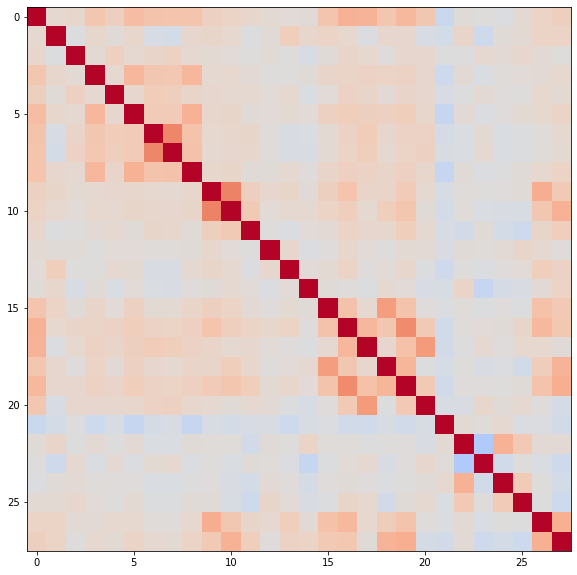

In [5]:
import bct 

data_non_qualitative = data_nonan.drop(columns=cualitative_cols)
covariance = data_non_qualitative.corr().values
covariance = np.nan_to_num(covariance)

ci,q = bct.modularity_louvain_und_sign(covariance)
#ci,q = bct.modularity_probtune_und_sign(covariance, ci=ci)   
bound, indsort = bct.grid_communities(ci)

ticks = np.arange(data_non_qualitative.columns.size)
print(ticks, indsort.size, covariance.shape)
plt.figure(figsize=(10,10))
plt.imshow(covariance, vmin=-1, vmax=+1, cmap="coolwarm")
plt.xticks(ticks, data_cualitative.columns, rotation=45, ha='right')
plt.yticks(ticks, data_cualitative.columns, rotation="horizontal")
plt.tight_layout()
plt.savefig("pearson_survey_order.pdf", bbox_inches="tight")
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(covariance[np.ix_(indsort, indsort)], cmap="coolwarm", interpolation="None", vmin=-1, vmax=1)
for index in bound:
    plt.axvline(index, color="#aaaaaa")
    plt.axhline(index, color="#aaaaaa")
plt.xticks(ticks, data_cualitative.columns[np.ix_(indsort)], rotation=45, ha='right')
plt.yticks(ticks, data_cualitative.columns[np.ix_(indsort)], rotation="horizontal")
plt.savefig("pearson_louvain_order.pdf", bbox_inches="tight")
plt.show()

Let us analyse what is the best way to add values to the missing fields of the table. We will use information we already have on the table to make an educated guess to fill them and help the network as much as possible. 

First, let's find out which employment codes correspond to health workers (HW), as well as some demographic correlation from them. A fast analysis reveals that there can be HW in _any_ registered industry, and in all occupations except one. However, HW only constitute around 10% of our population. 
Let's see the demographic differences in works between HW and non-HW, if any...

% of HW: 0.1085483206649942


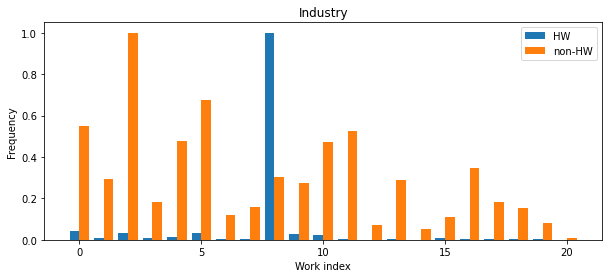

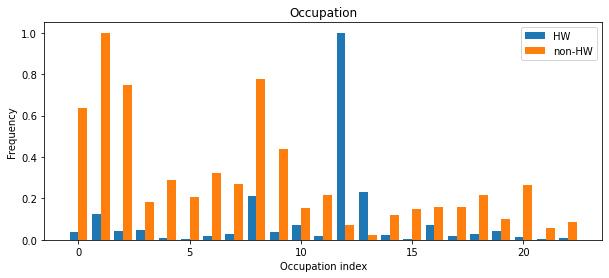

In [8]:
#Get who are health workers...
health_workers = data["health_worker"] == 1
nhw = health_workers.sum()

print("% of HW: {0}".format(nhw / data.shape[0]))

bins = np.arange(-0.5, n_classes[5]+0.5, 1.0)

#And the unique indices associated with them. Which % of the dataset they make?
industry_hw, _  = np.histogram(data["employment_industry"][health_workers], bins=bins)
industry_non_hw,_ = np.histogram(data["employment_industry"][~health_workers], bins=bins)


plt.figure(figsize=(10,4))
bar_w = 0.4
xaxis_l = bins[:-1] + 0.5 * (1 - bar_w)
xaxis_r = bins[:-1] + 0.5 * (1 + bar_w)
plt.bar(xaxis_l, industry_hw / np.max(industry_hw), width=bar_w, label="HW")
plt.bar(xaxis_r, industry_non_hw / np.max(industry_non_hw), width=bar_w, label="non-HW")
plt.xlabel("Work index")
plt.ylabel("Frequency")
plt.legend(loc="best")
plt.title("Industry")
plt.show()

bins = np.arange(-0.5, n_classes[6]+0.5, 1.0)

occupation_hw, _  = np.histogram(data["employment_occupation"][health_workers], bins=bins)
occupation_non_hw,_ = np.histogram(data["employment_occupation"][~health_workers], bins=bins)

plt.figure(figsize=(10,4))
bar_w = 0.4
xaxis_l = bins[:-1] + 0.5 * (1 - bar_w)
xaxis_r = bins[:-1] + 0.5 * (1 + bar_w)
plt.bar(xaxis_l, occupation_hw / np.max(occupation_hw), width=bar_w, label="HW")
plt.bar(xaxis_r, occupation_non_hw / np.max(occupation_non_hw), width=bar_w, label="non-HW")
plt.xlabel("Occupation index")
plt.ylabel("Frequency")
plt.legend(loc="best")
plt.title("Occupation")
plt.show()

del industry_hw, industry_non_hw, occupation_hw, occupation_non_hw, bins, xaxis_l, xaxis_r

Next step: we now know in what they work, then find how many of them are actually unemployed. Check also what is the correlation between employment, health insurance, and poverty risk.

Quite a big amount of them are "not in labor force"... does it mean that they are retired? Or what?

% not employed HW: 15.039668851328043
% not in labor HW: 12.969989651604001


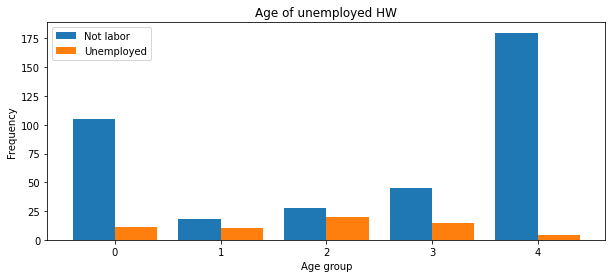

In [9]:
not_labor_employed_hw = (data["health_worker"] == 1) & (data["employment_status"] == 0)
unemployed_hw = (data["health_worker"] == 1) & (data["employment_status"] == 2)

total_not_working = not_labor_employed_hw.sum() +  unemployed_hw.sum()

print("% not employed HW: {0}".format(100* total_not_working / nhw))
print("% not in labor HW: {0}".format(100* not_labor_employed_hw.sum() / nhw))

age_not_labor = data["age_group"][not_labor_employed_hw]
age_unemp = data["age_group"][unemployed_hw]

bins = np.arange(-0.5, 5.5, 1.0)

age_not_labor, _  = np.histogram(age_not_labor, bins=bins)
age_unemp, _ = np.histogram(age_unemp, bins=bins)

plt.figure(figsize=(10,4))
bar_w = 0.4
xaxis_l = bins[:-1] + 0.5 * (1 - bar_w)
xaxis_r = bins[:-1] + 0.5 * (1 + bar_w)
plt.bar(xaxis_l, age_not_labor, width=bar_w, label="Not labor")
plt.bar(xaxis_r, age_unemp, width=bar_w, label="Unemployed")
plt.xlabel("Age group")
plt.ylabel("Frequency")
plt.title("Age of unemployed HW")
plt.legend(loc="best")
plt.show()

del not_labor_employed_hw, unemployed_hw, total_not_working, age_not_labor, age_unemp, _

Then, most of the HW which are "not in labor force" seem retired, followed by a large portion of students. Unemployed are evenly distributed, with worse situation for people around 50yo. 

Is this typical of HW, or is it something that happens at all levels? Let's check the age in general for the unemployed groups

% not employed: 42.09383307747033
% not in labor: 36.87797206724829


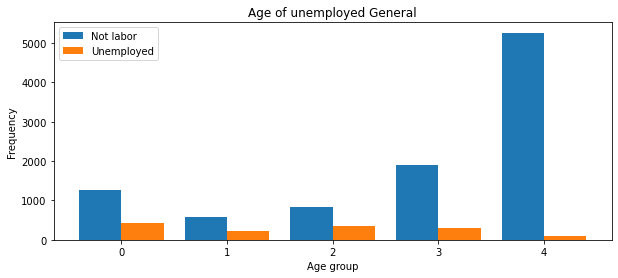

In [6]:
not_labor_employed=  (data["health_worker"] == 0) & (data["employment_status"] == 0)
unemployed = (data["health_worker"] == 0) & (data["employment_status"] == 2)

total_not_working = not_labor_employed.sum() +  unemployed.sum()

print("% not employed: {0}".format(100* total_not_working / data.shape[0]))
print("% not in labor: {0}".format(100* not_labor_employed.sum() / data.shape[0]))

age_not_labor = data["age_group"][not_labor_employed]
age_unemp = data["age_group"][unemployed]

bins = np.arange(-0.5, 5.5, 1.0)

age_not_labor, _  = np.histogram(age_not_labor, bins=bins)
age_unemp, _ = np.histogram(age_unemp, bins=bins)

plt.figure(figsize=(10,4))
bar_w = 0.4
xaxis_l = bins[:-1] + 0.5 * (1 - bar_w)
xaxis_r = bins[:-1] + 0.5 * (1 + bar_w)
plt.bar(xaxis_l, age_not_labor, width=bar_w, label="Not labor")
plt.bar(xaxis_r, age_unemp, width=bar_w, label="Unemployed")
plt.xlabel("Age group")
plt.ylabel("Frequency")
plt.title("Age of unemployed General")
plt.legend(loc="best")
plt.show()

del not_labor_employed, unemployed, total_not_working, age_not_labor, age_unemp, bins

Qualitatively the same, but the tendency for retired people is way larger most people "not in labor force" are retired. The unemployed situation did not change so much. 
Let's do a final one with ALL the demographics, including also the age distributions of people actually working. 

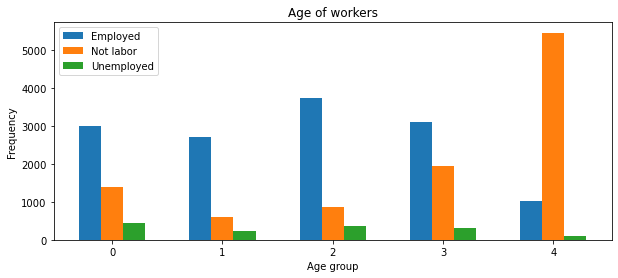

In [7]:
not_labor_employed= (data["employment_status"] == 0)
employed = (data["employment_status"] == 1)
unemployed = (data["employment_status"] == 2)

age_not_labor = data["age_group"][not_labor_employed]
age_emplo = data["age_group"][employed]
age_unemp = data["age_group"][unemployed]

bins = np.arange(-0.5, 5.5, 1.0)

age_not_labor, _  = np.histogram(age_not_labor, bins=bins)
age_emplo, _  = np.histogram(age_emplo, bins=bins)
age_unemp, _ = np.histogram(age_unemp, bins=bins)

plt.figure(figsize=(10,4))
bar_w = 0.2
xaxis_l = bins[:-1] + 0.5 - bar_w
xaxis_c = bins[:-1] + 0.5 
xaxis_r = bins[:-1] + 0.5 + bar_w
plt.bar(xaxis_l, age_emplo, width=bar_w, label="Employed")
plt.bar(xaxis_c, age_not_labor, width=bar_w, label="Not labor")
plt.bar(xaxis_r, age_unemp, width=bar_w, label="Unemployed")
plt.xlabel("Age group")
plt.ylabel("Frequency")
plt.title("Age of workers")
plt.legend(loc="best")
plt.show()

del not_labor_employed, unemployed, age_not_labor, age_unemp, bins, employed, age_emplo

Unemployement seems low for  age groups <55yo, and then it suddenly increases. On the other hand, there is a bunch of students in the first group. Ok, so let's take a look to these two sensitive group. How much money they make? Do they have healthcare?

% Healthcare total: 47.54184296251919
% Healthcare employed: 49.269911504424776
% Healthcare NOT employed: 45.75948885677341
% Healthcare OLD: 14.000074886733815
% Healthcare YOUNG: 7.900550417493541


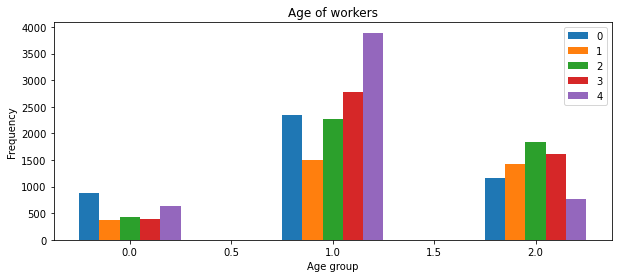

In [254]:
old_people = data["age_group"] == 4
young_people = data["age_group"] == 0

has_insurance = data["health_insurance"] == 1
employed = (data["employment_status"] == 1)

print("% Healthcare total: {0}".format( 100*(has_insurance).sum() /data.shape[0]))
print("% Healthcare employed: {0}".format( 100*(has_insurance & employed).sum() / employed.sum()))
print("% Healthcare NOT employed: {0}".format( 100*(has_insurance & ~employed).sum() / (~employed).sum()))

print("% Healthcare OLD: {0}".format( 100*(old_people & has_insurance).sum() /data.shape[0]))
print("% Healthcare YOUNG: {0}".format( 100*(young_people & has_insurance).sum() /data.shape[0]))

plt.figure(figsize=(10,4))

nbars = 5
half = nbars // 2
bins = np.arange(-0.5, 3.5, 1.0)
bar_w = 0.1

for bar in range(nbars):
    filter_age = data["age_group"] == bar
    income,_ = np.histogram(data["income_poverty"][filter_age], bins=bins)
    xaxis = bins[:-1] + 0.5 + (bar-half) *bar_w
    plt.bar(xaxis, income, width=bar_w, label=bar)
plt.xlabel("Age group")
plt.ylabel("Frequency")
plt.title("Age of workers")
plt.legend(loc="best")
plt.show()

del old_people, young_people, has_insurance, employed, bins, filter_age, income

The amount of people that does _not_ have healthcare is actually very worrisome. Even for the employed people, % is never higher than 50%. However it seems that unemployed people have it in the same amount. 
This could be a relevant point: if you don't have healthcare, _could your doctor recommend anything to you?_. If you don't have insurance, can you be diagnosed with chronic illnesses? Probably the combined effect of this variables has a huge impact on vaccination. Check it! 

Problem: there is MANY blank entries on health insurance, which coudl be a relevant variable. Let see if we can find where are those, correlating with age and employment.

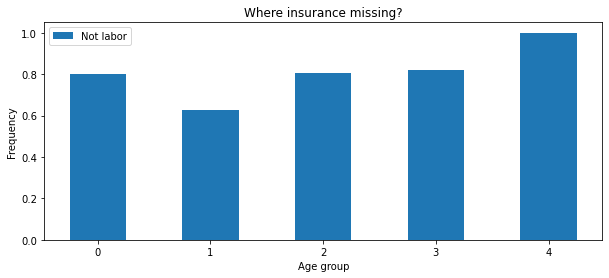

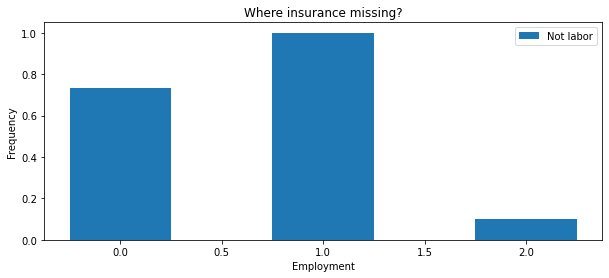

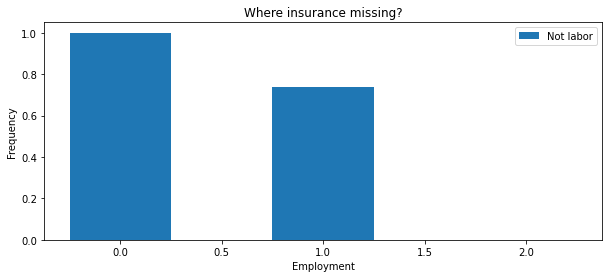

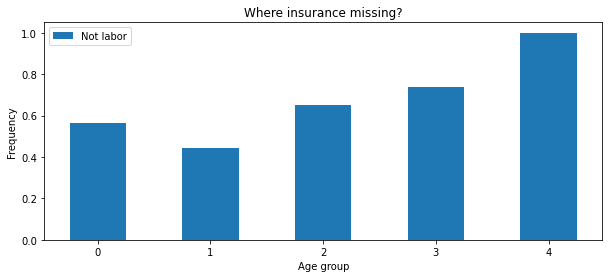

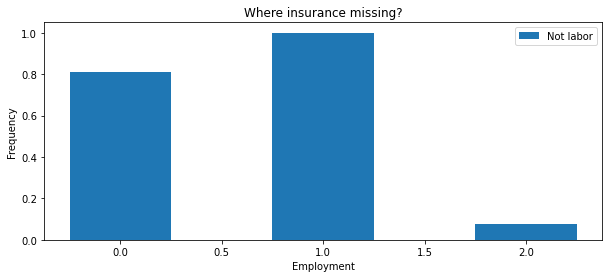

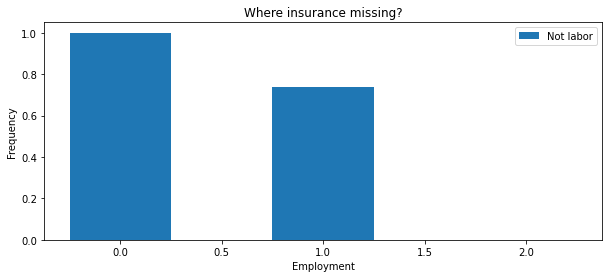

In [295]:
blank_insurance = data["health_insurance"].isna()
bins = np.arange(-0.5, 5.5, 1.0)

dist_blank, _  = np.histogram(data["age_group"][blank_insurance], bins=bins)

plt.figure(figsize=(10,4))
bar_w = 0.5
xaxis = bins[:-1] + 0.5 
plt.bar(xaxis, dist_blank/np.max(dist_blank), width=bar_w, label="Not labor")
plt.xlabel("Age group")
plt.ylabel("Frequency")
plt.title("Where insurance missing?")
plt.legend(loc="best")
plt.show()

bins = np.arange(-0.5, 3.5, 1.0)

dist_blank, _  = np.histogram(data["employment_status"][blank_insurance], bins=bins)

plt.figure(figsize=(10,4))
bar_w = 0.5
xaxis = bins[:-1] + 0.5 
plt.bar(xaxis, dist_blank/np.max(dist_blank), width=bar_w, label="Not labor")
plt.xlabel("Employment")
plt.ylabel("Frequency")
plt.title("Where insurance missing?")
plt.legend(loc="best")
plt.show()


dist_blank, _  = np.histogram(data["seasonal_vaccine"][blank_insurance], bins=bins)

plt.figure(figsize=(10,4))
bar_w = 0.5
xaxis = bins[:-1] + 0.5 
plt.bar(xaxis, dist_blank/np.max(dist_blank), width=bar_w, label="Not labor")
plt.xlabel("Employment")
plt.ylabel("Frequency")
plt.title("Where insurance missing?")
plt.legend(loc="best")
plt.show()


with_insurance = data["health_insurance"] == 1

bins = np.arange(-0.5, 5.5, 1.0)

dist_blank, _  = np.histogram(data["age_group"][with_insurance], bins=bins)

plt.figure(figsize=(10,4))
bar_w = 0.5
xaxis = bins[:-1] + 0.5 
plt.bar(xaxis, dist_blank/np.max(dist_blank), width=bar_w, label="Not labor")
plt.xlabel("Age group")
plt.ylabel("Frequency")
plt.title("Where insurance missing?")
plt.legend(loc="best")
plt.show()

bins = np.arange(-0.5, 3.5, 1.0)

dist_blank, _  = np.histogram(data["employment_status"][with_insurance], bins=bins)

plt.figure(figsize=(10,4))
bar_w = 0.5
xaxis = bins[:-1] + 0.5 
plt.bar(xaxis, dist_blank/np.max(dist_blank), width=bar_w, label="Not labor")
plt.xlabel("Employment")
plt.ylabel("Frequency")
plt.title("Where insurance missing?")
plt.legend(loc="best")
plt.show()

dist_blank, _  = np.histogram(data["seasonal_vaccine"][blank_insurance], bins=bins)

plt.figure(figsize=(10,4))
bar_w = 0.5
xaxis = bins[:-1] + 0.5 
plt.bar(xaxis, dist_blank/np.max(dist_blank), width=bar_w, label="Not labor")
plt.xlabel("Employment")
plt.ylabel("Frequency")
plt.title("Where insurance missing?")
plt.legend(loc="best")
plt.show()


1463
1250


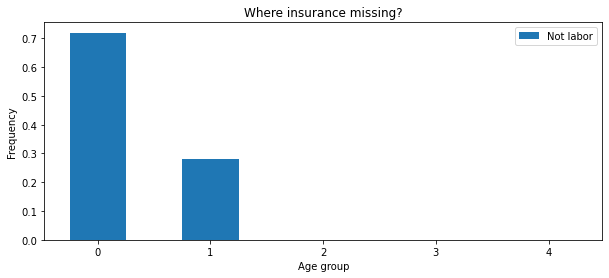

In [88]:
blank_insurance = data["employment_status"].isna()
bins = np.arange(-0.5, 5.5, 1.0)

print(data["employment_status"].isna().sum())
print((data["employment_status"].isna() & data["education"].isna()).sum())

dist_blank, _  = np.histogram(data["rent_or_own"][blank_insurance], bins=bins, density=True)

plt.figure(figsize=(10,4))
bar_w = 0.5
xaxis = bins[:-1] + 0.5 
plt.bar(xaxis, dist_blank, width=bar_w, label="Not labor")
plt.xlabel("Age group")
plt.ylabel("Frequency")
plt.title("Where insurance missing?")
plt.legend(loc="best")
plt.show()

# Model implementation
Here we implement a neural network to try to do the classification thing. 

First step is Torch tensor setup. We will 

1. Create input and target tensors, and get the indices of the columns that need to be one-hotted.
2. Define a function to create such onehots
3. Apply the function to generate the onehots and append them to the input tensor. Then, finally, delete the original columns which are no longer needed.

In [88]:
#Time has come

#Create input and target
inpt = torch.from_numpy(data_nonan.iloc[:,:-2].values)
target = torch.from_numpy(data_nonan.iloc[:,-2:].values)

print(inpt.shape, target.shape)

#Get the indices that correspond to the cualitative columns
cualitative_indices = torch.tensor([data.columns.get_loc(c) for c in cualitative_cols]).long()

torch.Size([26707, 35]) torch.Size([26707, 2])


In [89]:
def create_onehot(column, n_classes):
    """
    This function creates a one-hot vector given a column
    """
    
    column_onehot = torch.zeros(column.shape[0], n_classes)
    return column_onehot.scatter(index=column.unsqueeze(1).long(),value=1,dim=1)

In [90]:
#Apply the function above to create one-hot vectors
for cl,index in enumerate(cualitative_indices):
    one_hot_col = create_onehot(inpt[:,index], n_classes[cl])
    inpt = torch.cat((inpt,one_hot_col), 1)
    
print(inpt.shape)

#Create a mask which is "false" on the cualitative indices 
mask = torch.zeros(inpt.shape[1])
mask = ~mask.scatter(dim=0, index=cualitative_indices, value=1).bool()

#Apply the mask and reshape the result to get the final input vector...
nrows = inpt.shape[0]
inpt = torch.masked_select(inpt,mask).reshape(nrows, -1)
print(inpt.shape)

torch.Size([26707, 111])
torch.Size([26707, 102])


Now our input is ready. Let's work out the target. The idea is to set up 4 different classes, 00, 10, 01 and 11, so we need also one-hot vectors for all of this.

Finally, we will generate the train and test datasets and we're done

In [91]:
#Target is a 2-column vector with 0 or 1 that can be represented as binary (0-3) easily
target = (target[:,0] + 2 * target[:,1]).long()

#This function goes again from binary representation to two-column
def target_to_cols(target_tensor):
    first_digit = target_tensor.remainder(2)
    second_digit = target_tensor // 2
    
    return torch.stack((first_digit, second_digit), dim=1)

In [92]:
shuffled = torch.randperm(nrows)

n_test = int(0.2*nrows) #Use 20% as test set
train_ind = shuffled[:-n_test]
test_ind = shuffled[-n_test:]

#Get train and test data as views, as well as target results
#Set to float because in other case, model complains...
train_data = inpt[train_ind].float()
target_train = target[train_ind].long()

test_data = inpt[test_ind].float()
target_test = target[test_ind].long()

Once input and target have been finally computed, the next step is to do the classification model. We will use the following design:

1. The output of the network will be the probability of belonging to one of the classes. There is 4 classes, corresponding to vaccinated to none, one, or both vaccines: 00, 01, 10, and 11.

2. Error will be computed in the following way: once the probabilities are computed, the class is identified with the most probable class, and then the error is given by the mean square difference.

3. Once the model is trained and probabilities for the test set computed, since DataDriven challenge expects to have probs of both vaccines separately, these are computed from the p(H1N1, FLU) mass distribution. 

In [102]:
#Create the simples model ever, using as input the number of columns of the input
model = nn.Sequential(OrderedDict([
    ("h_lin", nn.Linear(inpt.shape[1], 10)), 
    ("h_tanh", nn.ReLU()),
    ("out_lin", nn.Linear(10, 4)),
    ("softmax", nn.LogSoftmax(dim=1))]))

print(model)
for (name,param) in model.named_parameters():
    print(name, param.shape)

Sequential(
  (h_lin): Linear(in_features=102, out_features=10, bias=True)
  (h_tanh): ReLU()
  (out_lin): Linear(in_features=10, out_features=4, bias=True)
  (softmax): LogSoftmax(dim=1)
)
h_lin.weight torch.Size([10, 102])
h_lin.bias torch.Size([10])
out_lin.weight torch.Size([4, 10])
out_lin.bias torch.Size([4])


In [95]:
def training_loop_with_test(n_epochs, optimizer, model, loss_fn, train_data, y_data, test_data, y_test):
    
    for epoch in range(1, n_epochs + 1):
        train_predict = model(train_data)
        train_loss = loss_fn(train_predict, y_data)
        
        with torch.no_grad():
            test_predict = model(test_data)
            test_loss = loss_fn(test_predict, y_test)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
            f" Validation loss {test_loss.item():.4f}")
    return 

def training_loop(n_epochs, optimizer, model, loss_fn, train_data, y_data):
    
    for epoch in range(1, n_epochs + 1):
        train_predict = model(train_data)
        train_loss = loss_fn(train_predict, y_data)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f}.")
    return 

In [105]:
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.0)

training_loop(n_epochs=1000, optimizer=optimizer, model=model, loss_fn=nn.NLLLoss(), 
              train_data=train_data, y_data=target_train)

Epoch 1, Training loss 0.7948.
Epoch 2, Training loss 0.7942.
Epoch 3, Training loss 0.7939.
Epoch 500, Training loss 0.7936.
Epoch 1000, Training loss 0.7935.


In [106]:
with torch.no_grad():
    _, pred = torch.max(model(test_data), dim=1)
    correct = (pred == target_test).sum()

roc_auc = roc_auc_score(target_to_cols(target_test), target_to_cols(pred), average="macro")
print("Accuracy: {0}%".format(100*correct / test_data.shape[0]))
print("AUC: {0}".format(roc_auc))


Accuracy: 67.59033966064453%
AUC: 0.7399904969527469


<ipython-input-91-9be30c59ebeb>:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  second_digit = target_tensor // 2


In [44]:
for check in torch.arange(20):
    print(torch.argmax(model(train_data)[check]))
    print(target_train[check])
    print("")

tensor(2)
tensor(2)

tensor(0)
tensor(0)

tensor(0)
tensor(0)

tensor(3)
tensor(0)

tensor(2)
tensor(3)

tensor(0)
tensor(0)

tensor(0)
tensor(0)

tensor(2)
tensor(2)

tensor(0)
tensor(3)

tensor(0)
tensor(0)

tensor(2)
tensor(2)

tensor(0)
tensor(0)

tensor(0)
tensor(0)

tensor(3)
tensor(3)

tensor(3)
tensor(3)

tensor(2)
tensor(2)

tensor(0)
tensor(0)

tensor(3)
tensor(2)

tensor(0)
tensor(0)

tensor(0)
tensor(0)



In [ ]:
#TODO: use the negative log loss, passing the correct arguments 
#to loss function (array of probabilities + label of the correct class) and check how it improves.